In [ ]:
from core.quantum_error_correction_code import SurfaceCode
from core.neural_network import CNNDual, load_params

import jax.numpy as jnp
from jax import random, vmap
from scipy.stats import beta
import matplotlib.pyplot as plt

key = random.key(42)

In [2]:
settings, decoder_params = load_params("data/general_distance3_decoder.json")
print(settings.keys())

CODE_DISTANCE = settings["CODE_DISTANCE"]
print(f"{CODE_DISTANCE = }")

DEFORMATION_OPTIONS = settings["DEFORMATION_OPTIONS"]
print(f"{DEFORMATION_OPTIONS = }")

ERROR_PROBS = settings["ERROR_PROBS"]
print(f"{ERROR_PROBS = }")

CONV_LAYERS_INPUT_1 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_1"]]
print(f"{CONV_LAYERS_INPUT_1 = }")

CONV_LAYERS_INPUT_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_2"]]
print(f"{CONV_LAYERS_INPUT_2 = }")

CONV_LAYERS_STAGE_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_STAGE_2"]]
print(f"{CONV_LAYERS_STAGE_2 = }")

FC_LAYERS = settings["FC_LAYERS"].tolist()
print(f"{FC_LAYERS = }")

dict_keys(['CODE_DISTANCE', 'DEFORMATION_OPTIONS', 'ERROR_PROBS', 'CONV_LAYERS_INPUT_1', 'CONV_LAYERS_INPUT_2', 'CONV_LAYERS_STAGE_2', 'FC_LAYERS'])
CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 1, 2, 3, 4, 5], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS_INPUT_1 = [(8, 2, 1, 0)]
CONV_LAYERS_INPUT_2 = [(8, 1, 1, 0)]
CONV_LAYERS_STAGE_2 = [(8, 2, 1, 0)]
FC_LAYERS = [50, 2]


In [3]:
def succes_counts(
    key,
    code: SurfaceCode,
    decoder: CNNDual,
    params: dict,
    noise_model: jnp.ndarray,
    shots: int,
    state: jnp.ndarray
):
    keys = random.split(key, num=shots+1)

    # Generate syndrome data for the deformation
    parity_info = code.deformation_parity_info(state)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(keys[:-1], noise_model)
    syndrome_img, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    deformation_image = code.deformation_image(state)

    # Predict the logical error
    predictions = decoder.apply_batch(
        params,
        syndrome_img[:, None, :, :],
        deformation_image,
    )
    predicted_logicals = (predictions > 0)

    # Compare prediction with the actual logical error
    error_count = jnp.any(
        logicals != predicted_logicals,
        axis=1
    ).sum()

    return error_count

Candidate A:


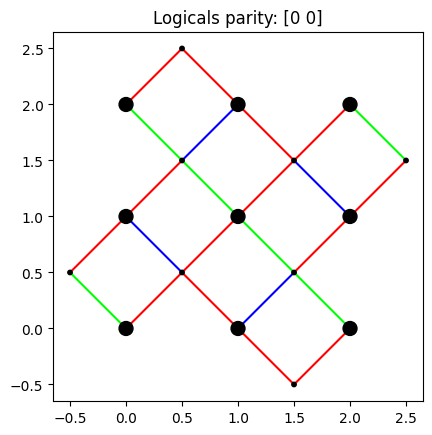

Candidate B:


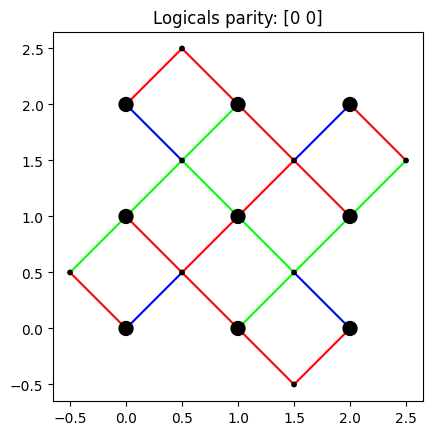

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(6, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [4]:
deformation_A = jnp.array([2,0,2,3,2,3,2,0,2])
deformation_B = jnp.array([3,2,0,2,2,2,0,2,3])

code = SurfaceCode(CODE_DISTANCE)
parity_info_A = code.deformation_parity_info(deformation_A)
parity_info_B = code.deformation_parity_info(deformation_B)
print("Candidate A:")
code.show(parity_info_A)
print("Candidate B:")
code.show(parity_info_B)

decoder_model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
display(decoder_model.layer_sizes)

Counts for deformation A = 8
Counts for deformation B = 20


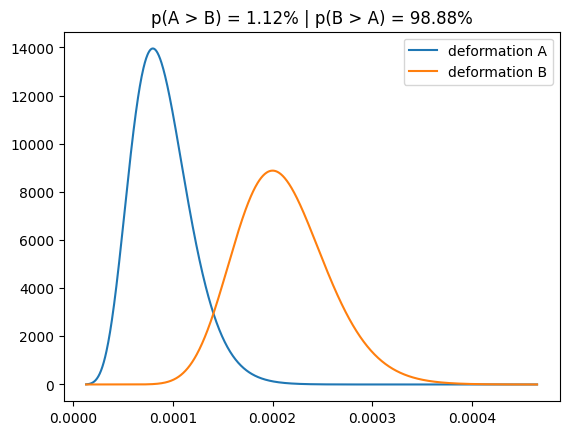

In [25]:
subkey, key = random.split(key)
shots = 100_000
count_A = succes_counts(
    subkey,
    code,
    decoder_model,
    decoder_params,
    ERROR_PROBS,
    shots,
    state=deformation_A
)
count_B = succes_counts(
    subkey,
    code,
    decoder_model,
    decoder_params,
    ERROR_PROBS,
    shots,
    state=deformation_B
)
print(f"Counts for deformation A = {count_A}")
print(f"Counts for deformation B = {count_B}")

dist_A = beta(count_A+1, shots-count_A+1)
dist_B = beta(count_B+1, shots-count_B+1)

confidence = 1E-5
p = jnp.linspace(
    min(dist_A.ppf(confidence), dist_B.ppf(confidence)),
    max(dist_A.ppf(1-confidence), dist_B.ppf(1-confidence)),
    1000
)
a = dist_A.pdf(p)
b = dist_B.pdf(p)

plt.figure()
plt.plot(p, a, label="deformation A")
plt.plot(p, b, label="deformation B")
plt.legend()
AgB = (dist_A.rvs(10000) > dist_B.rvs(10000)).mean()
plt.title(f"p(A > B) = {AgB:.2%} | p(B > A) = {1-AgB:.2%}")
plt.show()